In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Install pyreadr library
!pip install pyreadr

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Read the data from .RDS files
import pyreadr
data =  pyreadr.read_r('2019_1min_df.RDS')
df_2019 = data[None]
data = pyreadr.read_r('2020_1min_df.RDS')
df_2020 = data[None]
data = pyreadr.read_r('2021_1min_df.RDS')
df_2021 = data[None]
data = pyreadr.read_r('2022_1min_df.RDS')
df_2022 = data[None]
data = pyreadr.read_r('2023_1min_df.RDS')
df_2023 = data[None]

# Merge all the dataframes to form one dataframe.
df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df.shape

(2629440, 10)

In [4]:
df.isna().sum()

datetime_utc                           0
datetime_stamp                         0
Wells_Total_Discharge                  3
Chelan_Flow                          826
Entiat_Flow                        29756
Rocky_Reach_Total_Discharge          847
Wenatchee_Flow                        26
Rock_Island_Total_Discharge         1369
Rock_Island_Headwater_Elevation     1378
Rocky_Reach_Headwater_Elevation      893
dtype: int64

In [5]:
# Fill Null Values using foward fill and backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Modeling1 - Based on Calculations

### Rocky Reach Inflow Calculation

Wells Flow Impact = flows averaged from previous 90-105 minutes

Chelan Flow Impact = flows averaged from previous 62-77 minutes (60-75 should be fine)

Entiat Flow Impact = flows averaged from previous 15-30 minutes

Rocky Reach Inflow = Wells Flow Impact + Chelan Flow Impact + Entiat Flow Impact

In [6]:
# Convert 'datetime_utc' to datetime format
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

# Sort DataFrame by 'datetime_utc'
df.sort_values(by='datetime_utc', inplace=True)

# Calculate Wells Flow Impact
df['Wells_Flow_Impact'] = df['Wells_Total_Discharge'].shift(105).rolling(window=16).mean()
df['Wells_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Chelan Flow Impact
df['Chelan_Flow_Impact'] = df['Chelan_Flow'].shift(77).rolling(window=16).mean()
df['Chelan_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Entiat Flow Impact
df['Entiat_Flow_Impact'] = df['Entiat_Flow'].shift(30).rolling(window=16).mean()
df['Entiat_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Rocky Reach Inflow
df['Rocky_Reach_Inflow'] = df['Wells_Flow_Impact'] + df['Chelan_Flow_Impact'] + df['Entiat_Flow_Impact']

# Display the updated DataFrame
df[['datetime_utc', 'Wells_Flow_Impact', 'Chelan_Flow_Impact', 'Entiat_Flow_Impact', 'Rocky_Reach_Inflow']].head()

,datetime_utc,Wells_Flow_Impact,Chelan_Flow_Impact,Entiat_Flow_Impact,Rocky_Reach_Inflow
0,2019-01-01 08:00:00+00:00,56.139926,2.387459,0.0,58.527385
1,2019-01-01 08:01:00+00:00,56.139926,2.387459,0.0,58.527385
2,2019-01-01 08:02:00+00:00,56.139926,2.387459,0.0,58.527385
3,2019-01-01 08:03:00+00:00,56.139926,2.387459,0.0,58.527385
4,2019-01-01 08:04:00+00:00,56.139926,2.387459,0.0,58.527385


### Rock Island Inflow Calculation

Rocky Reach Flow Impact = Depends on Rocky Reach Total Discharge (RRTD) at time (now)
Wenatchee Flow Impact = flow from 22 minutes ago

Rocky Reach Flow Timing Logic:

If RRTD <= 50, then Rocky Reach Flow Impact = RRTD from 43 min ago

If RRTD > 50 & RRTD <= 80, then Rocky Reach Flow Impact = RRTD from 45 min ago

If RRTD > 80 & RRTD <= 120, then Rocky Reach Flow Impact = RRTD from 47 min ago

If RRTD > 120 & RRTD <= 150, then Rocky Reach Flow Impact = RRTD from 48 min ago

If RRTD > 150 & RRTD <= 220, then Rocky Reach Flow Impact = RRTD from 50 min ago

If RRTD > 220, then Rocky Reach Flow Impact = RRTD from 50 min ago

Rock Island Inflow = Rocky Reach Flow Impact + Wenatchee Flow Impact

In [7]:
# Define the conditions and corresponding shifts
conditions = [50, 80, 120, 150, 220]
shifts = [43, 45, 47, 48, 50]

# Calculate 'Rocky_Reach_Flow_Impact' in a vectorized way
df['Rocky_Reach_Flow_Impact'] = np.select(
    [df['Rocky_Reach_Total_Discharge'] <= condition for condition in conditions],
    [df['Rocky_Reach_Total_Discharge'].shift(shift) for shift in shifts],
    default=df['Rocky_Reach_Total_Discharge'].shift(50)
)
# For starting rows
df['Rocky_Reach_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate 'Wenatchee_Flow_Impact' with backward filling
df['Wenatchee_Flow_Impact'] = df['Wenatchee_Flow'].shift(22)
# For starting rows
df['Wenatchee_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate 'Rock Island Inflow'
df['Rock_Island_Inflow'] = df['Rocky_Reach_Flow_Impact'] + df['Wenatchee_Flow_Impact']

# Display the updated DataFrame
df[['datetime_utc', 'Rocky_Reach_Flow_Impact', 'Wenatchee_Flow_Impact', 'Rock_Island_Inflow']].head()

,datetime_utc,Rocky_Reach_Flow_Impact,Wenatchee_Flow_Impact,Rock_Island_Inflow
0,2019-01-01 08:00:00+00:00,72.28602,1.823813,74.109834
1,2019-01-01 08:01:00+00:00,72.28602,1.823813,74.109834
2,2019-01-01 08:02:00+00:00,72.28602,1.823813,74.109834
3,2019-01-01 08:03:00+00:00,72.28602,1.823813,74.109834
4,2019-01-01 08:04:00+00:00,72.28602,1.823813,74.109834


### Fill Rates

In [8]:
# Calculate fill rate at both dams
df['Rocky_Reach_Fill_Rate'] = df['Rocky_Reach_Inflow'] - df['Rocky_Reach_Total_Discharge']
df['Rock_Island_Fill_Rate'] = df['Rock_Island_Inflow'] - df['Rock_Island_Total_Discharge']

# Display the updated DataFrame
df[['Rocky_Reach_Fill_Rate','Rock_Island_Fill_Rate']].head()

,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate
0,-13.758636,-21.462003
1,-10.294244,-21.565912
2,-7.975250,-19.918337
3,-5.349238,-18.965717
4,-3.843683,-19.507878


### Headwater Elevation Change Vs Fill Rate

In [9]:
# Calculate the change in Rocky Reach headwater elevation
df['Rocky_Reach_Headwater_Elevation_Change'] = df['Rocky_Reach_Headwater_Elevation'].diff()
df['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

# Calculate the correlation between Rocky Reach Fill Rate and Headwater Elevation Change
rocky_reach_correlation = df['Rocky_Reach_Fill_Rate'].corr(df['Rocky_Reach_Headwater_Elevation_Change'])
print(f'Correlation between Rocky Reach Fill Rate and Headwater Elevation Change: {rocky_reach_correlation}')

Correlation between Rocky Reach Fill Rate and Headwater Elevation Change: 0.04955411341279833


Mean Squared Error for Rocky Reach Dam: 0.0013856120992723096
R-squared for Rocky Reach Dam: 0.002592150329449594


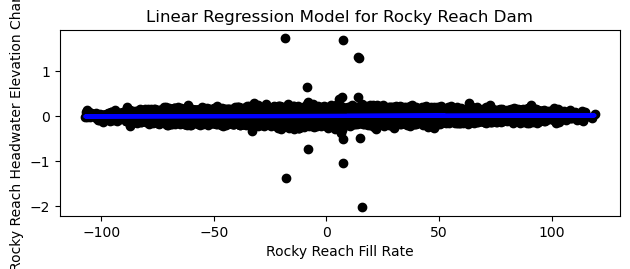

In [10]:
# Prepare data for modeling for Rocky Reach Dam
X_rocky_reach = df[['Rocky_Reach_Fill_Rate']]
y_rocky_reach = df['Rocky_Reach_Headwater_Elevation_Change']

# Split the data into training and testing sets
X_train_rocky_reach, X_test_rocky_reach, y_train_rocky_reach, y_test_rocky_reach = train_test_split(
    X_rocky_reach, y_rocky_reach, test_size=0.3,shuffle=False
)

# Create a linear regression model for Rocky Reach Dam
model_rocky_reach = LinearRegression()

# Train the model for Rocky Reach Dam
model_rocky_reach.fit(X_train_rocky_reach, y_train_rocky_reach)

# Make predictions on the test set for Rocky Reach Dam
y_pred_rocky_reach = model_rocky_reach.predict(X_test_rocky_reach)

# Evaluate the model for Rocky Reach Dam
mse_rocky_reach = mean_squared_error(y_test_rocky_reach, y_pred_rocky_reach)
r2_rocky_reach = r2_score(y_test_rocky_reach, y_pred_rocky_reach)

print(f'Mean Squared Error for Rocky Reach Dam: {mse_rocky_reach}')
print(f'R-squared for Rocky Reach Dam: {r2_rocky_reach}')

# Plot the regression line for Rocky Reach Dam
plt.subplot(2, 1, 2)
plt.scatter(X_test_rocky_reach, y_test_rocky_reach, color='black')
plt.plot(X_test_rocky_reach, y_pred_rocky_reach, color='blue', linewidth=3)
plt.title('Linear Regression Model for Rocky Reach Dam')
plt.xlabel('Rocky Reach Fill Rate')
plt.ylabel('Rocky Reach Headwater Elevation Change')

plt.tight_layout()
plt.show()

In [11]:
# Calculate the change in headwater elevation
df['Rock_Island_Headwater_Elevation_Change'] = df['Rock_Island_Headwater_Elevation'].diff()
df['Rock_Island_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df['Rock_Island_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)
# Calculate the correlation between Fill Rate and Headwater Elevation Change
correlation = df['Rock_Island_Fill_Rate'].corr(df['Rock_Island_Headwater_Elevation_Change'])
print(f'Correlation between Rock Island Fill Rate and Headwater Elevation Change: {correlation}')

Correlation between Rock Island Fill Rate and Headwater Elevation Change: 0.3351018220288469


Mean Squared Error for Rock Island Dam: 0.000442311208018728
R-squared for Rock Island Dam: 0.1299462484932471


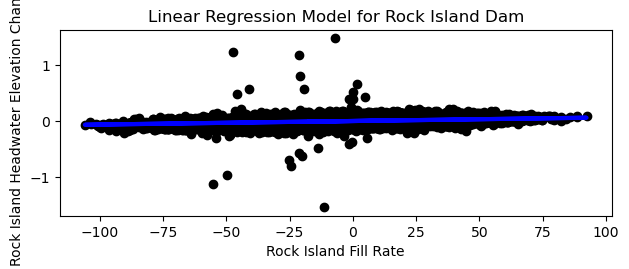

In [12]:
# Prepare data for modeling for Rock Island Dam
X_rock_island = df[['Rock_Island_Fill_Rate']]
y_rock_island = df['Rock_Island_Headwater_Elevation_Change']

# Split the data into training and testing sets
X_train_rock_island, X_test_rock_island, y_train_rock_island, y_test_rock_island = train_test_split(
    X_rock_island, y_rock_island, test_size=0.3, shuffle=False
)

# Create a linear regression model for Rock Island Dam
model_rock_island = LinearRegression()

# Train the model for Rock Island Dam
model_rock_island.fit(X_train_rock_island, y_train_rock_island)

# Make predictions on the test set for Rock Island Dam
y_pred_rock_island = model_rock_island.predict(X_test_rock_island)

# Evaluate the model for Rock Island Dam
mse_rock_island = mean_squared_error(y_test_rock_island, y_pred_rock_island)
r2_rock_island = r2_score(y_test_rock_island, y_pred_rock_island)

print(f'Mean Squared Error for Rock Island Dam: {mse_rock_island}')
print(f'R-squared for Rock Island Dam: {r2_rock_island}')

# Plot the regression line for Rock Island Dam
plt.subplot(2, 1, 2)
plt.scatter(X_test_rock_island, y_test_rock_island, color='black')
plt.plot(X_test_rock_island, y_pred_rock_island, color='blue', linewidth=3)
plt.title('Linear Regression Model for Rock Island Dam')
plt.xlabel('Rock Island Fill Rate')
plt.ylabel('Rock Island Headwater Elevation Change')

plt.tight_layout()
plt.show()

# Modeling2 - PCA

In [13]:
# Read the data from .RDS files
import pyreadr
data =  pyreadr.read_r('2019_1min_df.RDS')
df_2019 = data[None]
data = pyreadr.read_r('2020_1min_df.RDS')
df_2020 = data[None]
data = pyreadr.read_r('2021_1min_df.RDS')
df_2021 = data[None]
data = pyreadr.read_r('2022_1min_df.RDS')
df_2022 = data[None]
data = pyreadr.read_r('2023_1min_df.RDS')
df_2023 = data[None]

# Merge all the dataframes to form one dataframe.
df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.sort_values(by='datetime_utc', inplace=True)

# Fill Null Values using foward fill and backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [14]:
df.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation'],
      dtype='object')

## Rocky Reach

### Data Processing and Feature Engineering

In [15]:
# Rocky Reach Headwater Elevation lag for last 2 minutes
for lag in range(1, 3):
  df[f'Rocky_Reach_Headwater_Elevation_lag_{lag}'] = df['Rocky_Reach_Headwater_Elevation'].shift(lag)

# Rocky Reach Discharge lag for last 2 minutes
for lag in range(1, 3):
  df[f'Rocky_Reach_Total_Discharge_lag_{lag}'] = df['Rocky_Reach_Total_Discharge'].shift(lag)

# Wells Flow Impact = flows averaged from previous 90-105 minutes
for lag in range(90,106):
  df[f'Wells_Total_Discharge_lag_{lag}'] = df['Wells_Total_Discharge'].shift(lag)

# Chelan Flow Impact = flows averaged from previous 62-77 minutes (60-75 should be fine)
for lag in range(62, 78):
  df[f'Chelan_Flow_lag_{lag}'] = df['Chelan_Flow'].shift(lag)

# Entiat Flow Impact = flows averaged from previous 15-30 minutes
for lag in range(15, 31):
  df[f'Entiat_Flow_lag_{lag}'] = df['Entiat_Flow'].shift(lag)

df.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_Discharge_lag_101', 'Wells_Total_Discharge_lag_102',
       'Wells_Total_Discharge_lag_103', 'Wells_Total_Discharge_lag_104',
       'Wells_T

In [16]:
# List of unnecessary columns to drop
columns_to_drop = ['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge','Chelan_Flow', 'Entiat_Flow', 
                   'Wenatchee_Flow', 'Rock_Island_Total_Discharge', 'Rock_Island_Headwater_Elevation']

# Drop the unnecessary columns
df_rr = df.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_rr.dropna(inplace=True)


In [17]:
df_rr.shape

(2629335, 54)

### Principal Component Analysis (PCA) and Modeling

In [18]:
df_rr.columns

Index(['Rocky_Reach_Total_Discharge', 'Rocky_Reach_Headwater_Elevation',
       'Rocky_Reach_Headwater_Elevation_lag_1',
       'Rocky_Reach_Headwater_Elevation_lag_2',
       'Rocky_Reach_Total_Discharge_lag_1',
       'Rocky_Reach_Total_Discharge_lag_2', 'Wells_Total_Discharge_lag_90',
       'Wells_Total_Discharge_lag_91', 'Wells_Total_Discharge_lag_92',
       'Wells_Total_Discharge_lag_93', 'Wells_Total_Discharge_lag_94',
       'Wells_Total_Discharge_lag_95', 'Wells_Total_Discharge_lag_96',
       'Wells_Total_Discharge_lag_97', 'Wells_Total_Discharge_lag_98',
       'Wells_Total_Discharge_lag_99', 'Wells_Total_Discharge_lag_100',
       'Wells_Total_Discharge_lag_101', 'Wells_Total_Discharge_lag_102',
       'Wells_Total_Discharge_lag_103', 'Wells_Total_Discharge_lag_104',
       'Wells_Total_Discharge_lag_105', 'Chelan_Flow_lag_62',
       'Chelan_Flow_lag_63', 'Chelan_Flow_lag_64', 'Chelan_Flow_lag_65',
       'Chelan_Flow_lag_66', 'Chelan_Flow_lag_67', 'Chelan_Flow_lag_68',
 

In [19]:
# Separate features and target
target = 'Rocky_Reach_Headwater_Elevation'
X = df_rr.drop(columns=[target]) 
y = df_rr[target]  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

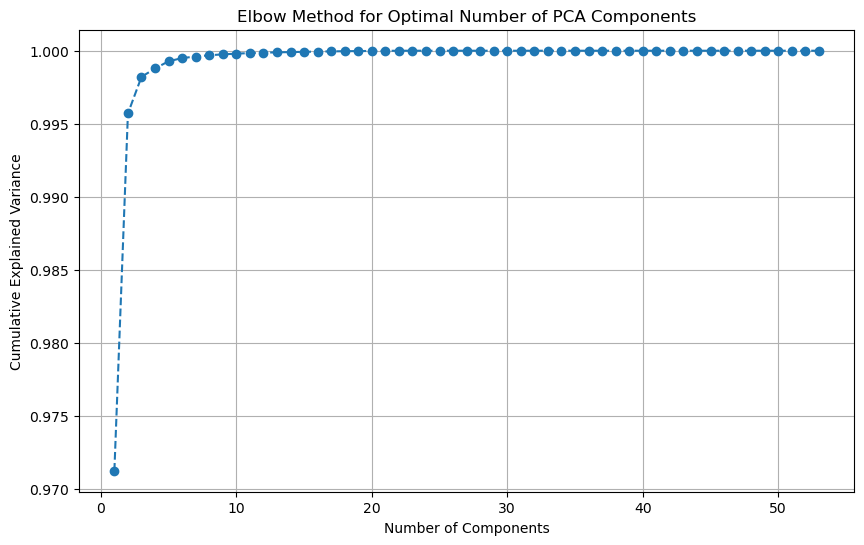

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
n_components = X.shape[1]

pca = PCA(n_components=n_components).fit(X)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for Optimal Number of PCA Components')
plt.grid(True)
plt.show()

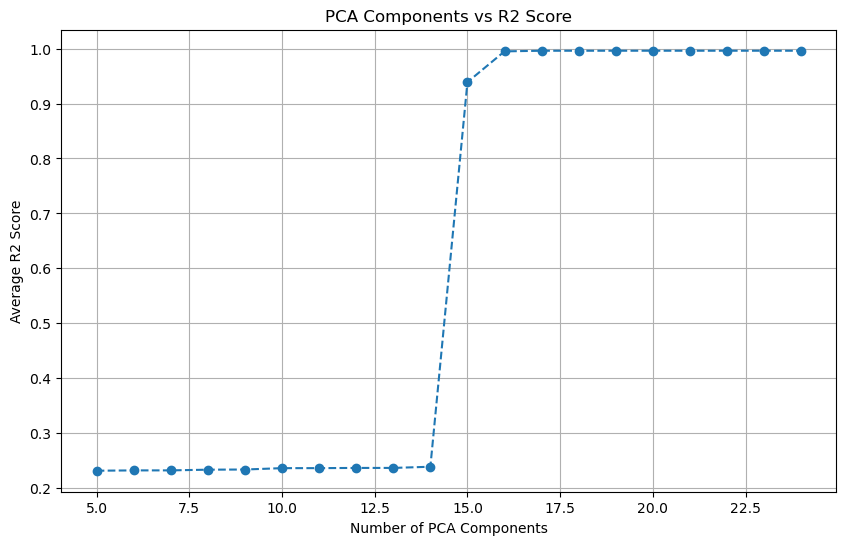

24

In [21]:
# Define a range of components to test
component_range = range(5, 25)

# Store the average cross-validation score for each number of components
cv_scores = []

# Set up cross-validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
for n_components in component_range:
    # Set up PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Transform X accordingly
    X_pca = pca.fit_transform(X)
    
    # Set up the regression model
    model = LinearRegression()
    
    # Perform cross-validation and store the average score
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='r2')
    cv_scores.append(np.mean(scores))

# Find the number of components with the best average CV score
optimal_components = component_range[np.argmax(cv_scores)]

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average R2 Score')
plt.title('PCA Components vs R2 Score')
plt.grid(True)
plt.show()

optimal_components

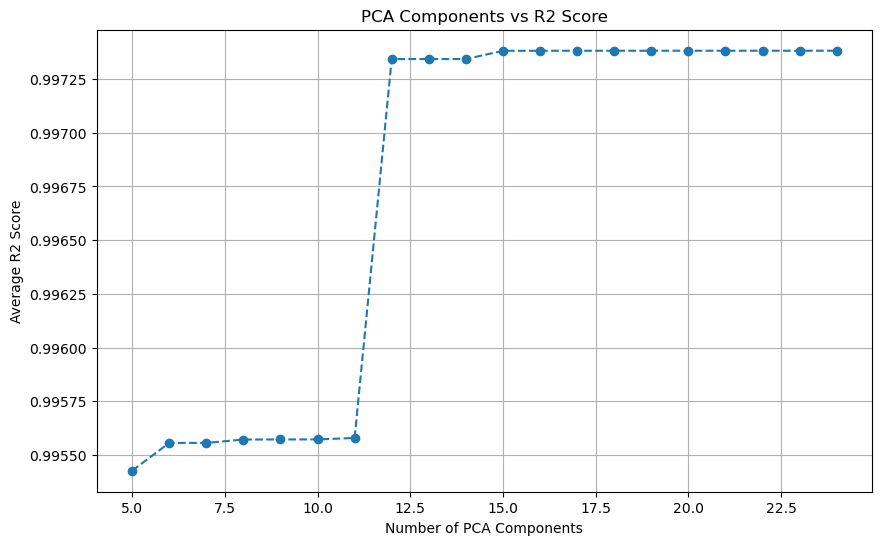

24

In [22]:
# Define a range of components to test
component_range = range(5, 25)

# Store the average cross-validation score for each number of components
cv_scores = []

# Set up cross-validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
for n_components in component_range:
    # Set up PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Transform X accordingly
    X_pca = pca.fit_transform(X_scaled)
    
    # Set up the regression model
    model = LinearRegression()
    
    # Perform cross-validation and store the average score
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='r2')
    cv_scores.append(np.mean(scores))

# Find the number of components with the best average CV score
optimal_components = component_range[np.argmax(cv_scores)]

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average R2 Score')
plt.title('PCA Components vs R2 Score')
plt.grid(True)
plt.show()

optimal_components

### Optimal Components - 16

In [23]:
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.002515953026137722
R-Squared for Rocky Reach Dam: 0.9942786545677632


In [24]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Wells_Total_Discharge_lag_101    10
Wells_Total_Discharge_lag_98     10
Wells_Total_Discharge_lag_97      9
Wells_Total_Discharge_lag_105     9
Wells_Total_Discharge_lag_90      9
Wells_Total_Discharge_lag_102     9
Wells_Total_Discharge_lag_93      9
Wells_Total_Discharge_lag_96      9
Wells_Total_Discharge_lag_94      8
Wells_Total_Discharge_lag_100     8
dtype: int64


### Trying Manual Components 10,20,30,40

#### 10 Components

In [25]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.3563923823836388
R-Squared for Rocky Reach Dam: 0.18955405452668916


In [26]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))


Most Influential Features in PCA:
Wells_Total_Discharge_lag_105    6
Wells_Total_Discharge_lag_90     6
Wells_Total_Discharge_lag_96     6
Wells_Total_Discharge_lag_99     5
Wells_Total_Discharge_lag_95     5
Wells_Total_Discharge_lag_100    5
Wells_Total_Discharge_lag_101    5
Wells_Total_Discharge_lag_93     5
Wells_Total_Discharge_lag_102    5
Wells_Total_Discharge_lag_98     4
dtype: int64


#### 20 Components

In [27]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model1.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0017837666881755324
R-Squared for Rocky Reach Dam: 0.9959436661624657


In [28]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Wells_Total_Discharge_lag_101    12
Wells_Total_Discharge_lag_96     12
Wells_Total_Discharge_lag_98     12
Wells_Total_Discharge_lag_97     11
Wells_Total_Discharge_lag_102    11
Wells_Total_Discharge_lag_93     11
Wells_Total_Discharge_lag_100    11
Wells_Total_Discharge_lag_95     11
Wells_Total_Discharge_lag_99     11
Wells_Total_Discharge_lag_94     10
dtype: int64


### 30 components

In [29]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model2.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0011116821184175333
R-Squared for Rocky Reach Dam: 0.9974720047058783


In [30]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Wells_Total_Discharge_lag_101    14
Wells_Total_Discharge_lag_96     14
Wells_Total_Discharge_lag_102    13
Wells_Total_Discharge_lag_98     13
Wells_Total_Discharge_lag_93     13
Wells_Total_Discharge_lag_97     12
Wells_Total_Discharge_lag_100    12
Wells_Total_Discharge_lag_95     12
Wells_Total_Discharge_lag_99     12
Wells_Total_Discharge_lag_94     11
dtype: int64


### 40 Components

In [31]:
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model3 = LinearRegression()
model3.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model3.predict(X_test)
print("Mean Squared Error for Rocky Reach Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rocky Reach Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rocky Reach Dam: 0.0011116869619729654
R-Squared for Rocky Reach Dam: 0.9974719936915019


In [32]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Wells_Total_Discharge_lag_96     14
Wells_Total_Discharge_lag_101    14
Wells_Total_Discharge_lag_98     13
Wells_Total_Discharge_lag_93     13
Wells_Total_Discharge_lag_102    13
Wells_Total_Discharge_lag_97     12
Wells_Total_Discharge_lag_99     12
Wells_Total_Discharge_lag_95     12
Wells_Total_Discharge_lag_100    12
Chelan_Flow_lag_70               12
dtype: int64


## Rock Island

In [33]:
# Read the data from .RDS files
import pyreadr
data =  pyreadr.read_r('2019_1min_df.RDS')
df_2019 = data[None]
data = pyreadr.read_r('2020_1min_df.RDS')
df_2020 = data[None]
data = pyreadr.read_r('2021_1min_df.RDS')
df_2021 = data[None]
data = pyreadr.read_r('2022_1min_df.RDS')
df_2022 = data[None]
data = pyreadr.read_r('2023_1min_df.RDS')
df_2023 = data[None]

# Merge all the dataframes to form one dataframe.
df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.sort_values(by='datetime_utc', inplace=True)

# Fill Null Values using foward fill and backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation'],
      dtype='object')

### Data Processing and Feature Engineering

In [34]:
# Create a list to hold all the new lagged feature DataFrames
lagged_features = []

# Rock Island Headwater Elevation lag for last 2 minutes
for lag in range(1, 3):
    lagged_feature = df['Rock_Island_Headwater_Elevation'].shift(lag).to_frame(f'Rocky_Island_Headwater_Elevation_lag_{lag}')
    lagged_features.append(lagged_feature)

# Rocky Island Discharge lag for last 2 minutes
for lag in range(1, 3):
    lagged_feature = df['Rock_Island_Total_Discharge'].shift(lag).to_frame(f'Rock_Island_Total_Discharge_lag_{lag}')
    lagged_features.append(lagged_feature)

# Wells Flow Impact = flows from last 15-30 minutes.
for lag in range(15, 30):
    lagged_feature = df['Wenatchee_Flow'].shift(lag).to_frame(f'Wenatchee_Flow_lag_{lag}')
    lagged_features.append(lagged_feature)

# Rocky Reach Discharge Impact = Discharge lags from last 10 to 30 minutes
for lag in range(10, 30):
    lagged_feature = df['Rocky_Reach_Total_Discharge'].shift(lag).to_frame(f'Rocky_Reach_Total_Discharge_lag_{lag}')
    lagged_features.append(lagged_feature)

# Concatenate all the lagged features with the original DataFrame
df = pd.concat([df] + lagged_features, axis=1)

In [35]:
df.shape

(2629440, 49)

In [36]:
df.columns

Index(['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
       'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
       'Wenatchee_Flow', 'Rock_Island_Total_Discharge',
       'Rock_Island_Headwater_Elevation', 'Rocky_Reach_Headwater_Elevation',
       'Rocky_Island_Headwater_Elevation_lag_1',
       'Rocky_Island_Headwater_Elevation_lag_2',
       'Rock_Island_Total_Discharge_lag_1',
       'Rock_Island_Total_Discharge_lag_2', 'Wenatchee_Flow_lag_15',
       'Wenatchee_Flow_lag_16', 'Wenatchee_Flow_lag_17',
       'Wenatchee_Flow_lag_18', 'Wenatchee_Flow_lag_19',
       'Wenatchee_Flow_lag_20', 'Wenatchee_Flow_lag_21',
       'Wenatchee_Flow_lag_22', 'Wenatchee_Flow_lag_23',
       'Wenatchee_Flow_lag_24', 'Wenatchee_Flow_lag_25',
       'Wenatchee_Flow_lag_26', 'Wenatchee_Flow_lag_27',
       'Wenatchee_Flow_lag_28', 'Wenatchee_Flow_lag_29',
       'Rocky_Reach_Total_Discharge_lag_10',
       'Rocky_Reach_Total_Discharge_lag_11',
       'Rocky_Reach_Total_Dischar

In [37]:
# List of columns to drop
columns_to_drop = ['datetime_utc', 'datetime_stamp', 'Wells_Total_Discharge',
                   'Chelan_Flow', 'Entiat_Flow', 'Rocky_Reach_Total_Discharge',
                   'Wenatchee_Flow', 'Rocky_Reach_Headwater_Elevation']

# Create the DataFrame df_ri by dropping the specified columns
df_ri = df.drop(columns=columns_to_drop).copy()

# Drop rows with missing values
df_ri.dropna(inplace=True)
df_ri.shape

(2629411, 41)

### Principal Component Analysis (PCA) and Modeling

In [38]:
# Separate features and target
target = 'Rock_Island_Headwater_Elevation'
X = df_ri.drop(columns=[target]) 
y = df_ri[target] #Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

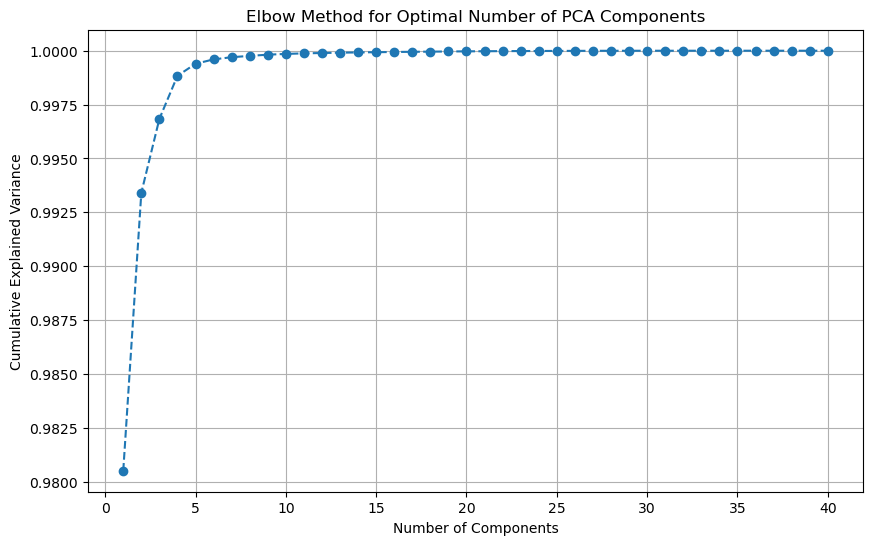

In [39]:
n_components = X.shape[1]

pca = PCA(n_components=n_components).fit(X)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for Optimal Number of PCA Components')
plt.grid(True)
plt.show()

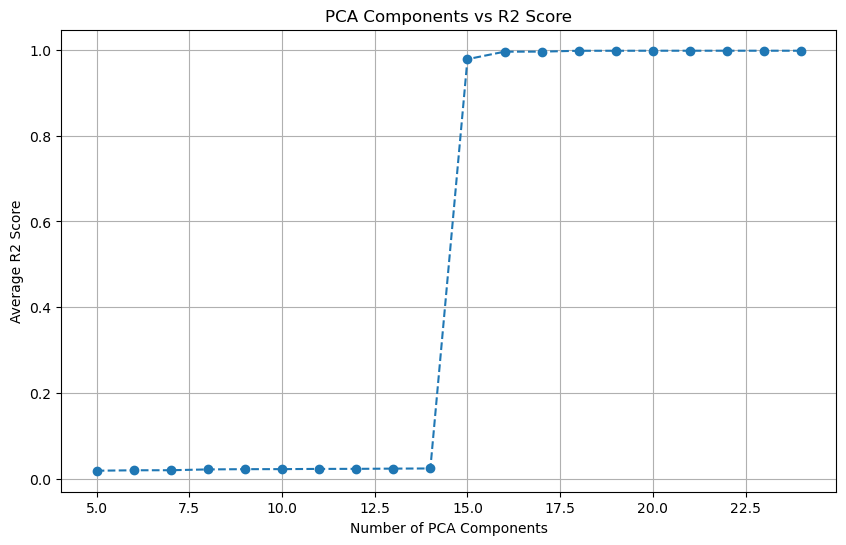

24

In [40]:
# Define a range of components to test
component_range = range(5, 25)

# Store the average cross-validation score for each number of components
cv_scores = []

# Set up cross-validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
for n_components in component_range:
    # Set up PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Transform X accordingly
    X_pca = pca.fit_transform(X)
    
    # Set up the regression model
    model = LinearRegression()
    
    # Perform cross-validation and store the average score
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='r2')
    cv_scores.append(np.mean(scores))

# Find the number of components with the best average CV score
optimal_components = component_range[np.argmax(cv_scores)]

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average R2 Score')
plt.title('PCA Components vs R2 Score')
plt.grid(True)
plt.show()

optimal_components

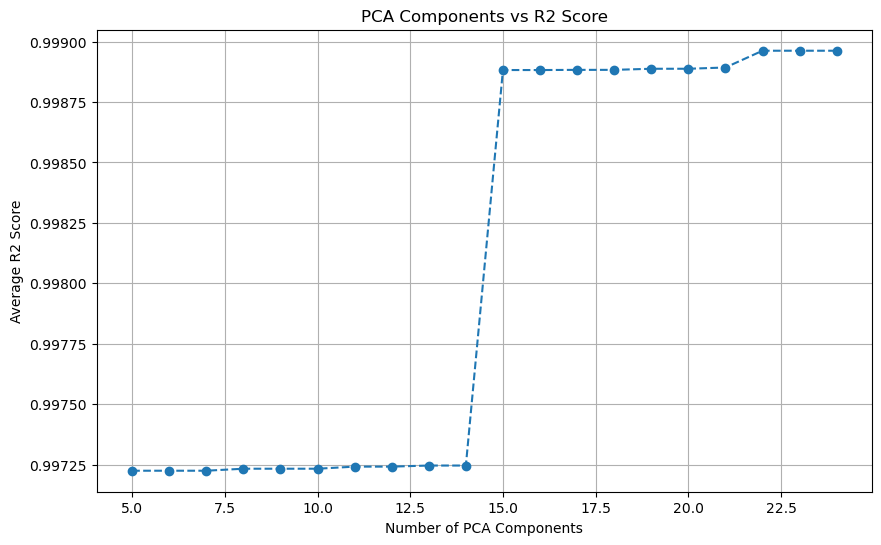

23

In [41]:
# Define a range of components to test
component_range = range(5, 25)

# Store the average cross-validation score for each number of components
cv_scores = []

# Set up cross-validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
for n_components in component_range:
    # Set up PCA with the current number of components
    pca = PCA(n_components=n_components)
    
    # Transform X accordingly
    X_pca = pca.fit_transform(X_scaled)
    
    # Set up the regression model
    model = LinearRegression()
    
    # Perform cross-validation and store the average score
    scores = cross_val_score(model, X_pca, y, cv=cv, scoring='r2')
    cv_scores.append(np.mean(scores))

# Find the number of components with the best average CV score
optimal_components = component_range[np.argmax(cv_scores)]

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Average R2 Score')
plt.title('PCA Components vs R2 Score')
plt.grid(True)
plt.show()

optimal_components

### Optimal Components - 16

In [42]:
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.000995625658721342
R-Squared for Rock Island Dam: 0.9954434483586553


In [43]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Rocky_Reach_Total_Discharge_lag_24    10
Rocky_Reach_Total_Discharge_lag_20     9
Rocky_Reach_Total_Discharge_lag_13     9
Rocky_Reach_Total_Discharge_lag_26     8
Rocky_Reach_Total_Discharge_lag_19     8
Rocky_Reach_Total_Discharge_lag_17     8
Rocky_Reach_Total_Discharge_lag_15     8
Rocky_Reach_Total_Discharge_lag_10     8
Rocky_Reach_Total_Discharge_lag_27     7
Rocky_Reach_Total_Discharge_lag_25     7
dtype: int64


### Trying Manually Components 10,20,30

#### 10 Components

In [44]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.2653944532445425
R-Squared for Rock Island Dam: -0.21459659154251698


In [45]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Rocky_Reach_Total_Discharge_lag_10    7
Rocky_Reach_Total_Discharge_lag_29    6
Rocky_Reach_Total_Discharge_lag_13    5
Rocky_Reach_Total_Discharge_lag_24    5
Rocky_Reach_Total_Discharge_lag_20    5
Rocky_Reach_Total_Discharge_lag_26    4
Rocky_Reach_Total_Discharge_lag_19    4
Rocky_Reach_Total_Discharge_lag_23    4
Rocky_Reach_Total_Discharge_lag_27    4
Rocky_Reach_Total_Discharge_lag_17    4
dtype: int64


#### 20 Components

In [46]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model1.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.0004911480813517889
R-Squared for Rock Island Dam: 0.9977522258726227


In [47]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Rocky_Reach_Total_Discharge_lag_24    12
Rocky_Reach_Total_Discharge_lag_20    10
Rocky_Reach_Total_Discharge_lag_13    10
Rocky_Reach_Total_Discharge_lag_26     9
Rocky_Reach_Total_Discharge_lag_19     9
Rocky_Reach_Total_Discharge_lag_15     9
Rocky_Reach_Total_Discharge_lag_17     9
Rocky_Reach_Total_Discharge_lag_21     8
Rocky_Reach_Total_Discharge_lag_10     8
Rocky_Reach_Total_Discharge_lag_11     8
dtype: int64


#### 30 Components

In [48]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, shuffle=False)

# Model training with Linear Regression
model2 = LinearRegression()
model2.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model2.predict(X_test)
print("Mean Squared Error for Rock Island Dam:", mean_squared_error(y_test, y_pred))
print("R-Squared for Rock Island Dam:", r2_score(y_test, y_pred))

Mean Squared Error for Rock Island Dam: 0.0004891557835176812
R-Squared for Rock Island Dam: 0.9977613437653633


In [49]:
# Features from the data
feature_names = X.columns

# Components given by pca
components = pca.components_

# Function to get top features for each component
def get_top_features_for_component(component, num_features):
    sorted_feature_indices = np.argsort(np.abs(component))[::-1][:num_features]
    return feature_names[sorted_feature_indices]

# Getting top 10 features for each component
num_top_features = 10 
top_features_per_component = {}

for i, component in enumerate(components):
    top_features = get_top_features_for_component(component, num_top_features)
    top_features_per_component[f"Component {i+1}"] = top_features

# Counting how often each feature appears in the top lists
feature_counts = pd.Series(np.concatenate(list(top_features_per_component.values()))).value_counts()

# Displaying the most frequently appearing features
print("Most Influential Features in PCA:")
print(feature_counts.head(10))

Most Influential Features in PCA:
Rocky_Reach_Total_Discharge_lag_24    16
Rocky_Reach_Total_Discharge_lag_20    13
Rocky_Reach_Total_Discharge_lag_15    13
Rocky_Reach_Total_Discharge_lag_17    13
Rocky_Reach_Total_Discharge_lag_13    13
Rocky_Reach_Total_Discharge_lag_26    12
Rocky_Reach_Total_Discharge_lag_19    12
Rocky_Reach_Total_Discharge_lag_16    12
Rocky_Reach_Total_Discharge_lag_21    11
Rocky_Reach_Total_Discharge_lag_11    11
dtype: int64
